Thi script evaluates the quality of the GSO estimated with the proposed proximal method when the graph filter H is perfectly known. We study wether the algorithm converges to a solution S, the error of the estimated S, and the time required to estimate S. 

In [1]:
import time

import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import data, opt
import utils.graph_denoising_opt as graph_denoising_opt

SEED = 456
np.random.seed(SEED)

### Estimate graph

In [2]:
## Experiment parameters

NN = [10, 25, 50]
list_iters = [50, 100, 250]
g_params = {'type': data.ER, 'p': .15}
noise = 0.05
eps = .05
K = 3

## Regularizers for PBCD
lamb_pbcd = .1
beta_pbcd = .01
gamma_pbcd = .1

## Regularizers for PPGD

lamb = 0.1 #0.001 # .01/5
beta = 0.01  #.5/5
gamma = 20 # 2
eta0 =  1e-4 # 1.5e-2  # 1e-4

# lamb = .01
# beta = .5
# gamma = 2
# eta0 = 1.5e-2  # 1e-4

times_pbcd = np.zeros((len(list_iters), len(NN)))
times = np.zeros((len(list_iters)+1, len(NN)))
err = np.zeros((len(list_iters)+1, len(NN)))
err_sym = np.zeros((len(list_iters)+1, len(NN)))
err_pbcd = np.zeros((len(list_iters), len(NN)))
Ss = []
Sns = []
Ss_hat = []
Ss_hat2 = []
for i, N in enumerate(NN):
    _, _, _, _, H, S, Sn, h = data.gen_data(N, 1, g_params, noise, eps, K, pert_type="prob", exp_coefs=True, coef=.9, seed=SEED)
    
    norm_H = la.norm(H,2)
    norm_S = np.linalg.norm(S, 'fro')
    # eta = eta0/norm_H
    eta = eta0
    err_S_Sn = la.norm(Sn/la.norm(Sn, 'fro') - S/norm_S, 'fro')**2
    print(f'N: {N}  -  Norm(S): {la.norm(S,2):.3f}  -  Norm(H): {la.norm(H,2):.3f}  -  eta: {eta:.6f}  -  norm(S-Sn): {err_S_Sn:4f}')
    
    Ss.append(S)
    Sns.append(Sn)
    Ss_hat.append(np.zeros((len(list_iters), N, N)))
    Ss_hat2.append(np.zeros((len(list_iters), N, N)))

    # Iterative methods
    for j, iters in enumerate(list_iters):
        # Projected Proximal Gradient Descent (PPGD)
        t = time.time()
        A_init = np.zeros((N,N))
        S_hat, s_iters = opt.proj_prox_A(Sn, H, eta, beta, lamb, gamma, A_init=A_init, max_iters=iters, verbose=False)
        times[j,i] = time.time() - t
        Ss_hat[i][j,:,:] = S_hat

        err[j,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        err_b = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2
        print(f'\t- PPGD (iters={iters}): time: {times[j, i]:.3f}s  - err (scale free): {err[j,i]:.3f} - err: {err_b:.3f}')


        # Projected Block Coordinate Desc (PBCD)
        t = time.time()
        S_hat, s_iters2 = graph_denoising_opt.efficient_graph_id(Sn, H, lamb_pbcd, beta_pbcd, gamma_pbcd, max_iters=iters, verbose=False)
        times_pbcd[j,i] = time.time() - t
        Ss_hat2[i][j,:,:] = S_hat 

        err_pbcd[j,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        err_b = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2
        print(f'\t- PBCD (iters={iters}): time: {times[j, i]:.3f}s  - err (scale free): {err_pbcd[j,i]:.3f} - err: {err_b:.3f}')

    # CVX step
    if N > 50:
        continue

    t = time.time()
    S_cvx = opt.graph_id(Sn, H, np.eye(N), lamb, gamma, delta=0)
    times[-1, i] = time.time() - t

    err[-1,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2
    err_b = np.linalg.norm(S_cvx - S, 'fro')**2/norm_S**2
    print(f'\t- CVX: time: {times[-1, i]:.3f}s  - err: {err[-1,i]:.3f} - err B: {err_b:.3f}')

N: 10  -  Norm(S): 2.486  -  Norm(H): 1.190  -  eta: 0.000100  -  norm(S-Sn): 0.093075
	- PPGD (iters=50): time: 0.003s  - err (scale free): 0.081 - err: 0.999
	- PBCD (iters=50): time: 0.019s  - err (scale free): 0.031 - err: 0.032
	- PPGD (iters=100): time: 0.005s  - err (scale free): 0.071 - err: 0.998
	- PBCD (iters=100): time: 0.018s  - err (scale free): 0.031 - err: 0.032
	- PPGD (iters=250): time: 0.010s  - err (scale free): 0.056 - err: 0.996
	- PBCD (iters=250): time: 0.018s  - err (scale free): 0.031 - err: 0.032
	- CVX: time: 0.019s  - err: 0.000 - err B: 0.000
N: 25  -  Norm(S): 4.025  -  Norm(H): 5.488  -  eta: 0.000100  -  norm(S-Sn): 0.300730
	- PPGD (iters=50): time: 0.004s  - err (scale free): 0.217 - err: 0.999


/home/srey/Investigacion/robust_gnn/opt.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  if i > 0 and la.norm(A - Aprev, 'fro')/la.norm(Aprev, 'fro') < eps:


	- PBCD (iters=50): time: 0.431s  - err (scale free): 0.009 - err: 0.009
	- PPGD (iters=100): time: 0.007s  - err (scale free): 0.159 - err: 0.998
	- PBCD (iters=100): time: 0.421s  - err (scale free): 0.009 - err: 0.009
	- PPGD (iters=250): time: 0.014s  - err (scale free): 0.097 - err: 0.997
	- PBCD (iters=250): time: 0.419s  - err (scale free): 0.009 - err: 0.009
	- CVX: time: 0.704s  - err: 0.000 - err B: 0.000
N: 50  -  Norm(S): 8.781  -  Norm(H): 11.069  -  eta: 0.000100  -  norm(S-Sn): 0.274376
	- PPGD (iters=50): time: 0.011s  - err (scale free): 0.077 - err: 0.999
	- PBCD (iters=50): time: 4.831s  - err (scale free): 0.001 - err: 0.001
	- PPGD (iters=100): time: 0.015s  - err (scale free): 0.035 - err: 0.998
	- PBCD (iters=100): time: 4.812s  - err (scale free): 0.001 - err: 0.001
	- PPGD (iters=250): time: 0.031s  - err (scale free): 0.012 - err: 0.996
	- PBCD (iters=250): time: 4.843s  - err (scale free): 0.001 - err: 0.001
	- CVX: time: 29.247s  - err: 0.000 - err B: 0.000


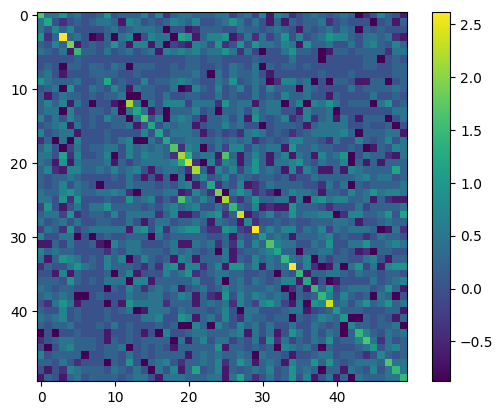

In [3]:
plt.figure()
plt.imshow(H)
plt.colorbar()

### Plot convergence

/tmp/ipykernel_822244/2981733601.py:3: RuntimeWarning: invalid value encountered in divide
  err_aux[i] = la.norm(s_iters[i]/la.norm(s_iters[i], 'fro') - S/norm_S, 'fro')**2


Text(0, 0.5, '|| S_i - S||_F^2')

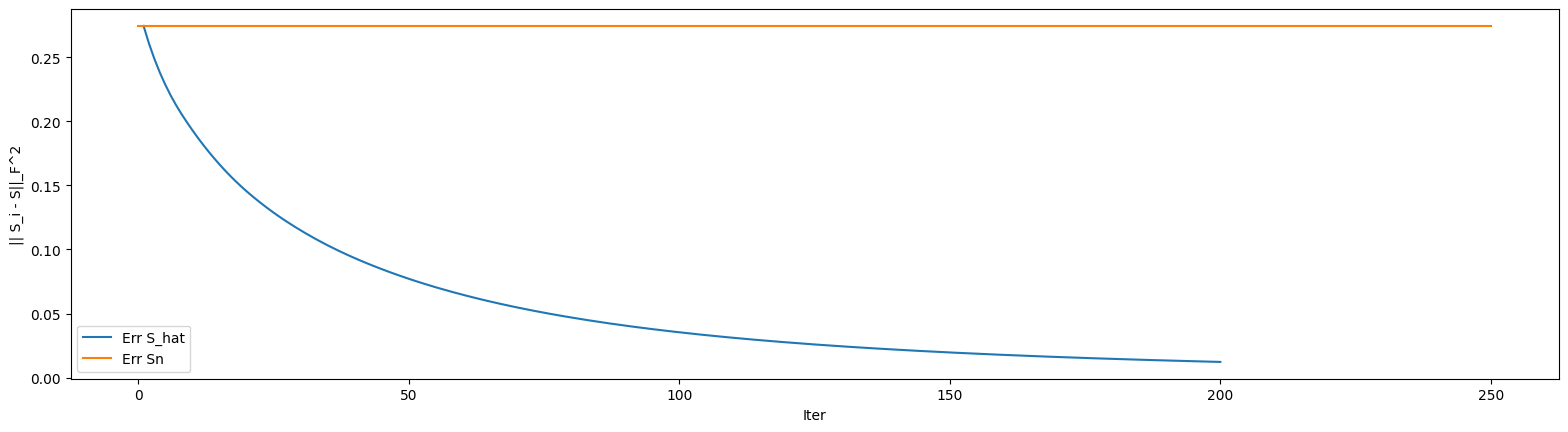

In [4]:
err_aux = np.zeros(iters+1)
for i in range(iters+1): 
    err_aux[i] = la.norm(s_iters[i]/la.norm(s_iters[i], 'fro') - S/norm_S, 'fro')**2

err_Sn = np.ones(iters+1)*la.norm(Sn/la.norm(Sn, 'fro') - S/norm_S, 'fro')**2

plt.figure(figsize=(19.2, 4.8))
plt.plot(err_aux)
plt.plot(err_Sn)
plt.legend(['Err S_hat', 'Err Sn'])
plt.xlabel('Iter')
plt.ylabel('|| S_i - S||_F^2')

### Plot graphs

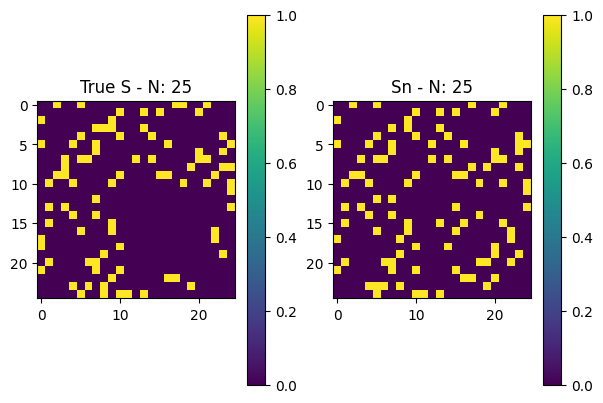

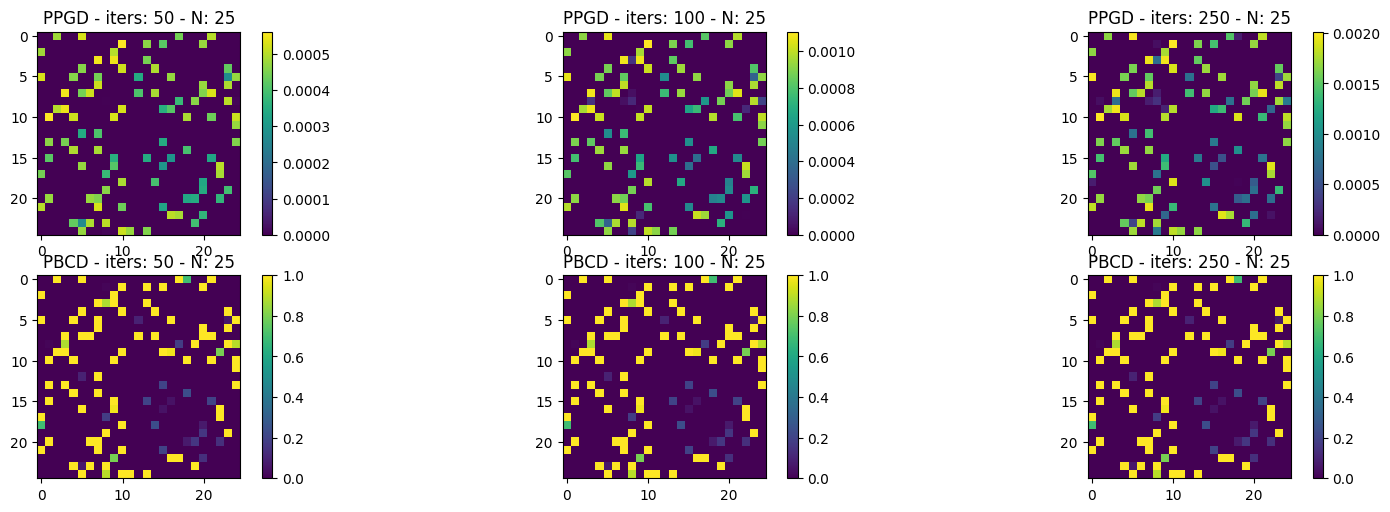

In [5]:
show_sizes = [25]
for i, N in enumerate(NN):
    if N not in show_sizes:
        continue

    plt.figure(figsize=(7, 4.8))
    plt.subplot(1, 2, 1)
    plt.imshow(Ss[i])
    plt.colorbar()
    plt.title(f'True S - N: {N}')
    plt.subplot(1, 2, 2)
    plt.imshow(Sns[i])
    plt.colorbar()
    plt.title(f'Sn - N: {N}')

    plt.figure(figsize=(19.2, 5.8))
    for j in range(len(list_iters)):
        plt.subplot(2, len(list_iters), j+1)
        plt.imshow(Ss_hat[i][j,:,:])
        plt.colorbar()
        plt.title(f'PPGD - iters: {list_iters[j]} - N: {N}')

        plt.subplot(2, len(list_iters), j+1+len(list_iters))
        plt.imshow(Ss_hat2[i][j,:,:])
        plt.colorbar()
        plt.title(f'PBCD - iters: {list_iters[j]} - N: {N}')


Text(0, 0.5, 'norm(s-s_hat)')

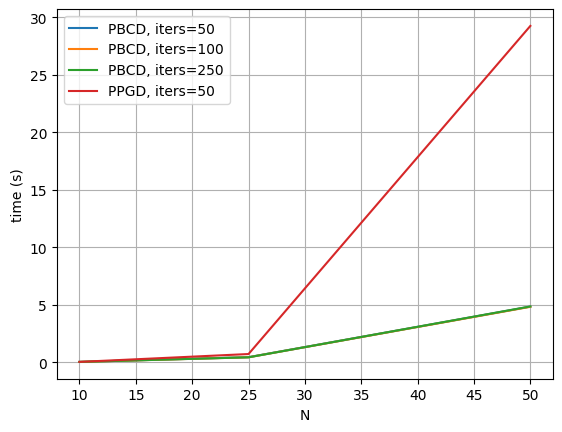

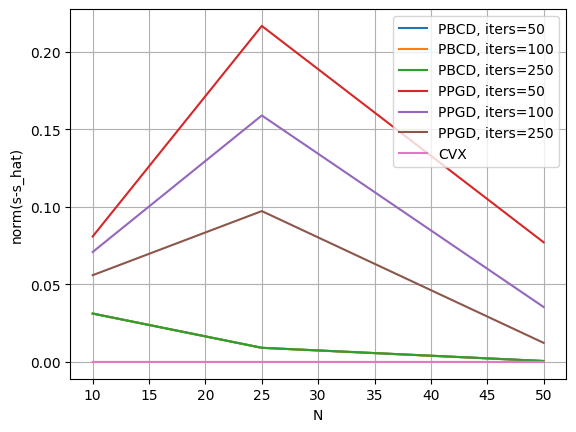

In [13]:
leg = [f'PBCD, iters={iters}' for iters in list_iters]
leg += [f'PPGD, iters={iters}' for iters in list_iters] + ['CVX']

# Plot time
plt.figure()
plt.plot(NN, times_pbcd.T)
plt.plot(NN, times.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
plt.plot(NN, err_pbcd.T)
plt.plot(NN, err.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')